# Python for Data Science — Final Project 

##### i. First I create a big dataframe including all the meta data information of the CommonVoice dataset.

In [1]:
import pandas as pd
import numpy as np
import os 
from pathlib import Path
import random
from polyglot.text import Text
from polyglot.detect import Detector
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
all_recordings = [path for path in Path("metadata").rglob('*.tsv') if path.stem in ("train", 'test')]
durations      = [path for path in Path("metadata").rglob('*.tsv') if path.stem in ("clip_durations")]

In [3]:
lst_dfs = []
for path in all_recordings:
    rec = pd.read_table(path, sep = '\t', engine='python', quoting=3)
    lst_dfs.append(rec)

In [4]:
big_df = pd.concat(lst_dfs, axis = 0, ignore_index = True)

In [5]:
lst_dur = []
for dur in durations:
    lst_dur.append(pd.read_table(dur, sep = '\t', engine='python', quoting=3).rename(columns = {"clip": "path"}))
    #if we merge the duration info simultaneously the merge operation creates many extra suffixed cols

In [6]:
big_df = big_df.merge(pd.concat(lst_dur, axis = 0, ignore_index = True), how="left", on = "path")

In [7]:
#The dataframe created eats up too much memory, which is not efficient for further data processing. free some memories by deleting useless cols
big_df.drop(columns = ["accents", "variant", "segment", "down_votes", "up_votes"], inplace=True)

In [266]:
big_df.memory_usage(deep = True)

Index            24784344
client_id       573137955
path            263409094
sentence        415338229
age             168109322
gender          162910767
locale          182904600
duration[ms]     24784344
dtype: int64

In [25]:
big_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265488 entries, 0 to 3265487
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   client_id     object
 1   path          object
 2   sentence      object
 3   age           object
 4   gender        object
 5   locale        object
 6   duration[ms]  int64 
dtypes: int64(1), object(6)
memory usage: 199.3+ MB


In [10]:
big_df.to_pickle("big_df.pkl")
#big_df = pd.read_pickle("big_df.pkl")

#### 1. For each language, determine the total duration of recording and the number of different speakers.

In [10]:
per_langs = big_df.groupby(["locale"]).agg({"client_id": "nunique", "duration[ms]": "sum"}).reset_index().rename(columns={"client_id": "#speakers"})
per_langs

,locale,#speakers,duration[ms]
0,ar,982,162160035
1,de,12277,3341755685
2,en,47864,6176752879
3,es,10990,1720018728
4,fr,12153,2820768179
5,id,332,42566295
6,it,5098,976196105
7,ja,1073,59117772
8,lg,540,501709546
9,ru,2144,192763014


#### 2. For each language and each genre determine the total duration of recordings, the number of different speakers, the average, median, min and max number of recordings per speaker.

In [11]:
# unfortunately we don't know lots of the gender of the data
big_df[big_df["gender"].isna()].shape[0]

936623

In [12]:
#fll the Nan value in gender column with a accustmed value "unk" stand for unknown;
#big_df["gender"].fillna("unk", inplace = True)

In [13]:
per_gender = big_df.groupby(["locale", "gender"]).agg({"client_id": "nunique", "duration[ms]": "sum"}).reset_index().rename(columns={"client_id": "#speakers"})
per_gender.head(10)

,locale,gender,#speakers,duration[ms]
0,ar,female,87,26649792
1,ar,male,301,35590808
2,ar,other,8,149616
3,de,female,576,256048399
4,de,male,3111,1857171870
5,de,other,50,24376606
6,en,female,3178,1212660279
7,en,male,11394,2966205993
8,en,other,330,131645246
9,es,female,1095,474956697


In [14]:
#the number of different speakers, the average, median, min and max number of recordings per speaker.
basic_stats = big_df.groupby(["locale", "gender", "client_id"]).agg({"duration[ms]": ["sum", "mean", "min", "median", "min", "max"]})
basic_stats.head(10)

duration[ms]  \
                                                                          sum   
locale gender client_id                                                         
ar     female 07c0f649c0a682a4cc331f40608540184830d6b8240a600...        16740   
              07d78b74bf6b7759f7faf624f207e2d61f18d3618470b21...        66576   
              09b463abdff70b941e2e3e6fd6d220ccc2feb24c36523b0...       107520   
              0af6153d77410b38e305641df97147dc3ef12fd60addcd9...        55440   
              0fd4b81cf2260b46a28d660e5db0008639aca2304f0c938...       321516   
              115a898d89f11f5d78ac0ad8e071c08bb35d1d76e6a2bac...        49056   
              13727dbeddbad8abcef97333b0109a321c8affad216ee63...        31176   
              177bee55973286de1b2bab468270e4deb5ab33583a20967...         8064   
              1ebda36c79c7942d2d10a68236599dd5be279fcf6f17adb...      1032624   
              2c1c6088204f735de177d61cd8aa000be8a060ef5357c55...       137484   

                                                                               \
                                                                         mean   
locale gender client_id                                                         
ar     female 07c0f649c0a682a4cc331f40608540184830d6b8240a600...  3348.000000   
              07d78b74bf6b7759f7faf624f207e2d61f18d3618470b21...  3916.235294   
              09b463abdff70b941e2e3e6fd6d220ccc2feb24c36523b0...  3707.586207   
              0af6153d77410b38e305641df97147dc3ef12fd60addcd9...  3261.176471   
              0fd4b81cf2260b46a28d660e5db0008639aca2304f0c938...  5023.687500   
              115a898d89f11f5d78ac0ad8e071c08bb35d1d76e6a2bac...  4459.636364   
              13727dbeddbad8abcef97333b0109a321c8affad216ee63...  7794.000000   
              177bee55973286de1b2bab468270e4deb5ab33583a20967...  8064.000000   
              1ebda36c79c7942d2d10a68236599dd5be279fcf6f17adb...  4081.517787   
              2c1c6088204f735de177d61cd8aa000be8a060ef5357c55...  4910.142857   

                                                                        \
                                                                   min   
locale gender client_id                                                  
ar     female 07c0f649c0a682a4cc331f40608540184830d6b8240a600...  3168   
              07d78b74bf6b7759f7faf624f207e2d61f18d3618470b21...  2736   
              09b463abdff70b941e2e3e6fd6d220ccc2feb24c36523b0...  2472   
              0af6153d77410b38e305641df97147dc3ef12fd60addcd9...  2448   
              0fd4b81cf2260b46a28d660e5db0008639aca2304f0c938...  2736   
              115a898d89f11f5d78ac0ad8e071c08bb35d1d76e6a2bac...  2856   
              13727dbeddbad8abcef97333b0109a321c8affad216ee63...  3924   
              177bee55973286de1b2bab468270e4deb5ab33583a20967...  8064   
              1ebda36c79c7942d2d10a68236599dd5be279fcf6f17adb...  2088   
              2c1c6088204f735de177d61cd8aa000be8a060ef5357c55...  2340   

                                                                          \
                                                                  median   
locale gender client_id                                                    
ar     female 07c0f649c0a682a4cc331f40608540184830d6b8240a600...  3348.0   
              07d78b74bf6b7759f7faf624f207e2d61f18d3618470b21...  3864.0   
              09b463abdff70b941e2e3e6fd6d220ccc2feb24c36523b0...  3408.0   
              0af6153d77410b38e305641df97147dc3ef12fd60addcd9...  3168.0   
              0fd4b81cf2260b46a28d660e5db0008639aca2304f0c938...  4824.0   
              115a898d89f11f5d78ac0ad8e071c08bb35d1d76e6a2bac...  4296.0   
              13727dbeddbad8abcef97333b0109a321c8affad216ee63...  8406.0   
              177bee55973286de1b2bab468270e4deb5ab33583a20967...  8064.0   
              1ebda36c79c7942d2d10a68236599dd5be279fcf6f17adb...  3636.0   
              2c1c6088204f735de177d61cd8aa000be8a060ef5357c55...  4374.0   

     

#### 3. Which language has the highest proportion of recordings by a person in the oldest age bracket considered ?
\
Answer: It is Arabic.

In [22]:
big_df["age"].unique() #the oldiest is 90s

array(['twenties', 'teens', nan, 'thirties', 'fifties', 'fourties',
       'nineties', 'seventies', 'sixties', 'eighties'], dtype=object)

<Axes: ylabel='age'>

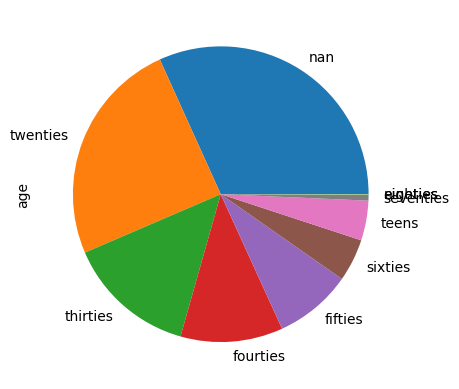

In [23]:
#find the largest age bracket across languages
big_df["age"].value_counts(dropna = False).plot(kind = "pie")

I found two solutons to find the language with the highest proportion of recordings by a person in the 90s. I hope I understand your question correctly.

In [36]:
# 1st
percent = (big_df[big_df["age"] == "nineties"].groupby(["locale", "client_id"])["duration[ms]"].sum() / big_df[big_df["age"] == "nineties"].groupby(["locale"])["duration[ms]"].sum()).reset_index().rename(columns = {"duration[ms]": "%"})
percent.loc[percent["%"].idxmax()]

locale                                                      ar
client_id    0e68ec0efd84a7584b516991849470ecfdac7466619031...
%                                                          1.0
Name: 0, dtype: object

In [34]:
#2nd
todo      = big_df[big_df["age"] == "nineties"].groupby(["locale", "client_id"])["duration[ms]"].sum().reset_index()

todo      = todo[todo["duration[ms]"] == todo.groupby(["locale"])["duration[ms]"].transform("max")].reset_index(drop = True)

todo["%"] =  (todo[todo["duration[ms]"] == todo.groupby(["locale"])["duration[ms]"].transform("max")].reset_index(drop = True)["duration[ms]"]) / (big_df[big_df["age"] == "nineties"].groupby("locale").sum().reset_index()["duration[ms]"])

todo.loc[todo["%"].idxmax()]

/tmp/ipykernel_8296/1196285286.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  todo["%"] =  (todo[todo["duration[ms]"] == todo.groupby(["locale"])["duration[ms]"].transform("max")].reset_index(drop = True)["duration[ms]"]) / (big_df[big_df["age"] == "nineties"].groupby("locale").sum().reset_index()["duration[ms]"])


locale                                                         ar
client_id       0e68ec0efd84a7584b516991849470ecfdac7466619031...
duration[ms]                                                16920
%                                                             1.0
Name: 0, dtype: object

#### 4. Determine the number of different genres considered in the corpus. What is the percentage of recordings for which no genre information is available ? Plot the genre distribution (including cases where gender information is not available). Do the same for ages.
There are all together 3 genders: male, female and other.

In [80]:
#big_df["gender"].fillna("unk", inplace = True)

<Axes: ylabel='gender'>

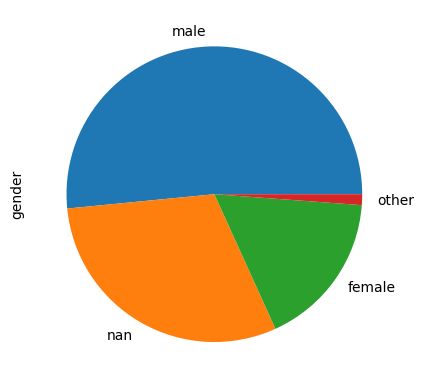

In [84]:
big_df["gender"].value_counts(dropna = False).plot(kind = "pie")

In [20]:
#the percentage of recording with no gender information
percent_nan = big_df[big_df["gender"].isna()].shape[0] / big_df.shape[0]
print(f"{percent_nan}")

0.30232730791664286


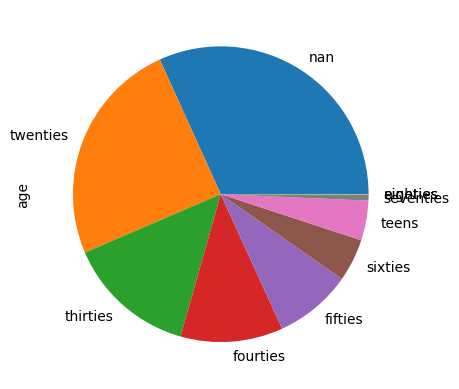

In [85]:
percentage_unk_age = big_df["age"].value_counts(dropna = False).plot(kind = "pie")

In [23]:
#the percentage of recording with no age information
big_df[big_df["age"].isna()].shape[0] / big_df.shape[0]

0.31760985886896986

#### 5. Find out for each language and each genre the 7 speakers who produced the most recordings. 
Do you mean for each language and each gender aggregated or separately?
The following script gives result for each language and for each gender in the language.

In [24]:
big_df.groupby(["locale", "gender", "client_id"]).count().sort_values(by = ["locale", "gender", "path"], ascending = False).groupby(["locale", "gender"]).head(7)[["path", "sentence"]]

path  \
locale gender client_id                                                  
zh-CN  other  d13b5607fe6e9d844674b6da98598a98ada7324425926ee...   227   
              36004c895c66dd44c4324df2cf5a082b9fba86d58892e0d...     9   
              8a2fc21b44d2c005616923c7997aac35e2d19e640b806c7...     7   
              b06ee136b9ab85349742e4bdb3d976d49ec971b37e0389d...     4   
              9bdbe9c49cc619513057e43ecb888570c176b6027fcf031...     3   
...                                                                ...   
ar     female fc3b87e39142b5fced5eb2422f0f5277bdf471c8865e9a2...   526   
              d7517b67ab736aa3e93a6ff78544e9f6e5be25406515228...   492   
              c8a5a7e7ec79a0962b671878dc7de66774a4c7c58afb3a3...   399   
              897226a3aa51a7aa3533ac9f4370c2a346f21e343fbcb21...   388   
              1ebda36c79c7942d2d10a68236599dd5be279fcf6f17adb...   253   

                                                                  sentence  
locale gender client_id                                                     
zh-CN  other  d13b5607fe6e9d844674b6da98598a98ada7324425926ee...       227  
              36004c895c66dd44c4324df2cf5a082b9fba86d58892e0d...         9  
              8a2fc21b44d2c005616923c7997aac35e2d19e640b806c7...         7  
              b06ee136b9ab85349742e4bdb3d976d49ec971b37e0389d...         4  
              9bdbe9c49cc619513057e43ecb888570c176b6027fcf031...         3  
...                                                                    ...  
ar     female fc3b87e39142b5fced5eb2422f0f5277bdf471c8865e9a2...       526  
              d7517b67ab736aa3e93a6ff78544e9f6e5be25406515228...       492  
              c8a5a7e7ec79a0962b671878dc7de66774a4c7c58afb3a3...       399  
              897226a3aa51a7aa3533ac9f4370c2a346f21e343fbcb21...       388  
              1ebda36c79c7942d2d10a68236599dd5be279fcf6f17adb...       253  

[267 rows x 2 columns]

The following scripts are results for each language:

In [25]:
big_df.groupby(["locale", "client_id"]).count().sort_values(by = ["locale", "path"], ascending = False).head(7)[["path", "sentence"]]

path  sentence
locale client_id                                                         
zh-CN  25bc975d06200b7b1c9135db090561cb0d9b28d172e51c6...  1284      1284
       55a7e303bbc54b407ccdc5789dc21cf745ab32adf489603...   886       886
       f0252fe7cd2777b74b4dae00914cc45370bd1ac3383fa41...   723       723
       e51fa51c0f709d1309d6015a2789a1ccf1398578fa260bb...   658       658
       cf7f4dc457a2d4f9e9f26016ab5d24c5b5551ec3512cce1...   626       626
       f827a323522967ff2766b5f2f073876621b753f5ce5989c...   509       509
       c0fca24743c1f119512e86296a1d2ae730c6af85f4be721...   471       471

The following scripts are results for each gender:

In [25]:
big_df.groupby(["gender", "client_id"]).count().sort_values(by = ["gender", "path"], ascending = False).head(7)[["path", "sentence"]]

path  sentence
gender client_id                                                         
other  7963691c43c8cc498c58f117527522bf772c76c38530570...  8137      8137
       87840e4d3db1e4e6262c86f580eafda6f5a5b61747333e5...  2731      2731
       923d18708f2b76a24c4e5e835d208c5d4f45a33af40c7ff...  1440      1440
       4c9c8cbd6e079193d65a7e04f31a0dfae0fb5fd58f2b35b...   814       814
       0933d3fdcc6d51036d7f36a5bacad3bfb08209417bd2a36...   768       768
       90295c02b177679e5f97729c8abc0128f1a7d045e94c2c3...   676       676
       dc3db1a53620d85b9664bf89a66c12905ad39c9c4cd2bf5...   667       667

#### 6. For each language, create a 1-hour test set and a training set as large as possible, ensuring that speakers from the test set do not appear in the training set.

First, I add a column that tag each recording as belonging either training or test set, and then I extract the paths based on the information provided by "split" column. I suppose that what we want is to build a list of paths for train data.

In [28]:
def split_train_test_for_all_languages(df, test_duration=60 * 60 * 1_000):
    
    df['split'] = np.where(df.groupby('locale')['duration[ms]'].transform('cumsum') <= test_duration, 'test', 'train')
    
    data_dict = {lang: {"train": grp[grp['split'] == 'train']['path'].tolist(),
                        "test": grp[grp['split'] == 'test']['path'].tolist()}
                 for lang, grp in df.groupby('locale')}
    return data_dict

In [42]:
data_dict = split_train_test_for_all_languages(big_df)

In [46]:
data_dict["en"]['test'][:10]

['common_voice_en_19734332.mp3',
 'common_voice_en_19734337.mp3',
 'common_voice_en_19734341.mp3',
 'common_voice_en_19734343.mp3',
 'common_voice_en_24638324.mp3',
 'common_voice_en_24638331.mp3',
 'common_voice_en_24638336.mp3',
 'common_voice_en_24638338.mp3',
 'common_voice_en_19372667.mp3',
 'common_voice_en_19372668.mp3']

#### 7. How many languages have more female than male recordings ?
 There are 3.

In [26]:
per_gender = big_df.groupby(["locale", "gender"])["path"].count().reset_index().rename(columns = {"path": "#recordings"})
pivot_table= per_gender.pivot_table(index='locale', columns='gender', values='#recordings', aggfunc='sum', fill_value=0)
pivot_table.query('female > male')

gender,female,male,other
locale,,,
lg,39158,24880,0
sw,18960,14768,0
ta,12170,10694,17


#### 8. Which language has the most unbalanced gender distribution ? 
Answer: It is "Dutch". 87% of the recordings are male.

In [27]:
(per_gender.groupby(["locale", "gender"])["#recordings"].sum() / 
 per_gender.groupby("locale")["#recordings"].sum()).agg(["max" , "idxmax"])

max         0.868448
idxmax    (de, male)
Name: #recordings, dtype: object

#### 9. For each language, create a train set containing 1 hour of recordings and a 10-minute test set so that : i) train and test are gender-balanced ii) the train and test speakers are different.
Follow the same principles as question 6, I added some conditions so that the constraints are satified. However, I did not find a simple oneline method to do it.

Notes: even if there are three possible genders(male, female and other), the gender "other" is rather underrepresented. So if I take all three genders into account, for some languages I cannot generate a balanced train set because there is not enough records with the gender "other". So for practical reason I only chose to generate balanced dataset on gender of female and male.

In [30]:
train_duration = 60 * 60 * 1_000
test_duration  = 10 * 60 * 1_000

In [31]:
#to mark recordings within train set
genders = ['female', 'male']
#condition on the length of total duration and gender
big_df['split'] = np.where((big_df.groupby(['locale', "gender"])['duration[ms]'].transform('cumsum') <= train_duration//2) & (big_df["gender"].isin(genders)),  'train', np.nan)

In [32]:
#to mark recording within testset test set
#first condition specify that the row cannot have the same id as rows in train
condition1 = (big_df['gender'].isin(genders) & ~big_df['client_id'].isin(big_df.loc[big_df['split'] == 'train', 'client_id'])) 
big_df['split'] = np.where(condition1, 'test_candidate', big_df['split'])

condition2 = (big_df.groupby(['locale', "gender", "split"])['duration[ms]'].transform('cumsum') <= test_duration//2) & big_df["split"].isin(["test_candidate"])
big_df['split'] = np.where(condition2, "test", big_df["split"])

In [33]:
big_df[big_df['split'].isin(["train","test"])].groupby(["locale", "split"])["duration[ms]"].sum()

locale  split
ar      test      594576
        train    3598236
de      test      593700
        train    3593424
en      test      595679
        train    3596575
es      test      598476
        train    3593312
fr      test      596304
        train    3596172
id      test      595608
        train    3595860
it      test      593832
        train    3594874
ja      test      594384
        train    3591672
lg      test      593640
        train    3596688
ru      test      595212
        train    3591396
sw      test      589428
        train    3597912
ta      test      595752
        train    3591912
tr      test      596448
        train    3595824
zh-CN   test      596028
        train    3598284
Name: duration[ms], dtype: int64

In [259]:
balanced_data_dict = {lang: {"train": grp[grp['split'] == 'train']['path'].tolist(), "test": grp[grp['split'] == 'test']['path'].tolist()} for lang, grp in big_df.groupby('locale')}

#### 10. Plot, for each language, a box plot representing the distribution of the number of words per sentence.

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/xin/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [6]:
big_df = big_df.dropna(subset = ["sentence"]) 

In [7]:
big_df["#toks"] = big_df["sentence"].apply(lambda x: len(TextBlob(x).words))

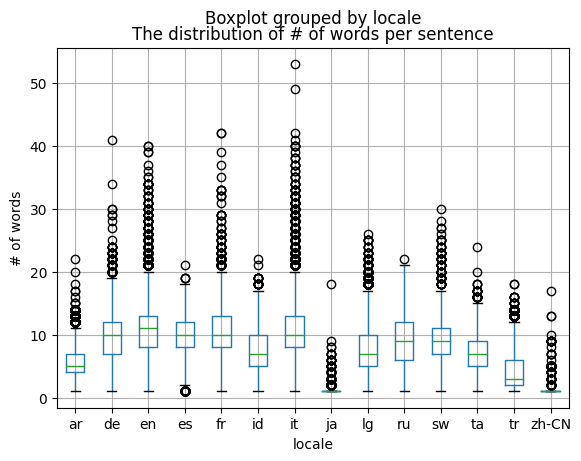

In [37]:
big_df.boxplot(["#toks"], by = "locale")
plt.title("The distribution of # of words per sentence")
plt.ylabel("# of words")
plt.show()

#### 11. For each language, find the 17 most frequent words after having removed stop words. 
The multilingual stopwords resource I found is here https://github.com/stopwords-iso/stopwords-iso.  It covers all the languages in the dataset.

In [11]:
import stopwordsiso as stopwords
import string

In [13]:
df = big_df.groupby("locale")["sentence"].agg(list).reset_index()
df["toks_freq"] = df["sentence"].apply(lambda x : Counter(TextBlob(" ".join(x).lower()).words)) #get every tokens in the corpus and their frequencies

Here is an explanation why I use TextBlob and Polyglot together on the same dataset:
At first I tried to run polyglot tokenizer on the whole corpus, the machine crashed everytime even on colab, then I switch to TextBlob which is a lighter module and it runs.
However, The Textblob doesn't work for scripts like Japanese and Chinese, it fails to tokenize the characters in these two languages. So for Japanese and Chinese I have to tokenize them separately with polyglot tokenizer.

In [43]:
df[df["locale"] == "ja"] # the TextBlob fails to tokenize Japanese sentence

,locale,sentence,toks_freq,17_most_freq
7,ja,"[この肉がいちばん安いです。, アメリカが風邪をひけば、日本もクシャミをする、といわれる程で...","{'この肉がいちばん安いです。': 1, 'アメリカが風邪をひけば、日本もクシャミをする、と...","[('s, 3), (girls, 2), (edward, 2), (，, 2), (tr..."


In [46]:
df.loc[df["locale"] == "ja", "toks_freq"] = df[df["locale"] == "ja"]["sentence"].apply(lambda x : Counter(Text(" ".join(x).lower()).words)) 
df.loc[df["locale"] == "zh-CN", "toks_freq"] = df[df["locale"] == "zh-CN"]["sentence"].apply(lambda x : Counter(Text(" ".join(x).lower()).words)) 

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   locale        14 non-null     object
 1   sentence      14 non-null     object
 2   toks_freq     14 non-null     object
 3   17_most_freq  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [48]:
#remove all the stopwords, I think I will remove the common punctuations, too. They are not informative in this scenario yet very frequent.
sws = stopwords.stopwords(df["locale"].tolist()).union(set(string.punctuation).union({"„", "“", "؟", "。", "—", "–", " 、", "”", "«", "’", "‘"}))
df["toks_freq"] = df["toks_freq"].apply(lambda x: Counter({tok: freq for tok, freq in x.items() if tok not in sws}))

In [49]:
df["17_most_freq"] = df["toks_freq"].apply(lambda x: x.most_common(17))
df[["locale", "17_most_freq"]]

,locale,17_most_freq
0,ar,"[(سامي, 1732), (مِنْ, 1359), (فِي, 1201), (مَا..."
1,de,"[(liegt, 6795), (stadt, 5309), (befindet, 4628..."
2,en,"[('s, 70624), (school, 18263), (time, 14811), ..."
3,es,"[(ciudad, 4831), (años, 4355), (nombre, 4035),..."
4,fr,"[(également, 14116), (c'est, 12063), (d'un, 83..."
5,id,"[(tom, 240), (orang, 233), (memiliki, 221), (k..."
6,it,"[(viene, 3607), (venne, 2714), (film, 2435), (..."
7,ja,"[(、, 7295), (した, 2244), (的, 1641), (ま, 1161), ..."
8,lg,"[(ku, 15450), (nga, 10636), (nti, 6223), (aban..."
9,ru,"[(должны, 662), (является, 606), (безопасности..."


12. Compute, for each language, the size of the available data both in term of duration and in
terms of number of words.

In [15]:
big_df.groupby(["locale"]).agg({ "duration[ms]": "sum", "#toks" : "sum"})

,duration[ms],#toks
locale,,
ar,162160035,220005
de,3341753141,5583769
en,6176752879,11156526
es,1720018728,3256049
fr,2820768179,5510207
id,42566295,67180
it,976196105,1801070
ja,59117772,12597
lg,501709546,663080


### 2 Measuring the similarity between American presidents speeches

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from collections import defaultdict
import seaborn as sns

In [89]:
all_speechs = list(sorted(Path("US_Inaugural_Addresses").rglob('*.txt'), key = lambda path: int(path.stem.rsplit("_")[0]) ))

In [90]:
data = {"path": [], "corpus": []}

for path in all_speechs:
    with open(path, "r") as f:
        text = f.read()
        data['path'].append(str(path).split("/")[1])
        data["corpus"].append(text)

In [91]:
vectorizer = TfidfVectorizer(stop_words =  "english")
vectors    = vectorizer.fit_transform(data["corpus"])

In [92]:
cos_similarity = cosine_similarity(vectors, vectors)

In [93]:
data["vectors"] = vectors

In [94]:
us_df   = pd.DataFrame({"path": data["path"]})

In [95]:
us_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    58 non-null     object
dtypes: object(1)
memory usage: 592.0+ bytes


In [96]:
for i in range(len(data["path"])):
    us_df[data["path"][i]] = cos_similarity[i]

In [97]:
cosine_sim_df = pd.DataFrame(cos_similarity, columns=data["path"], index=data["path"])

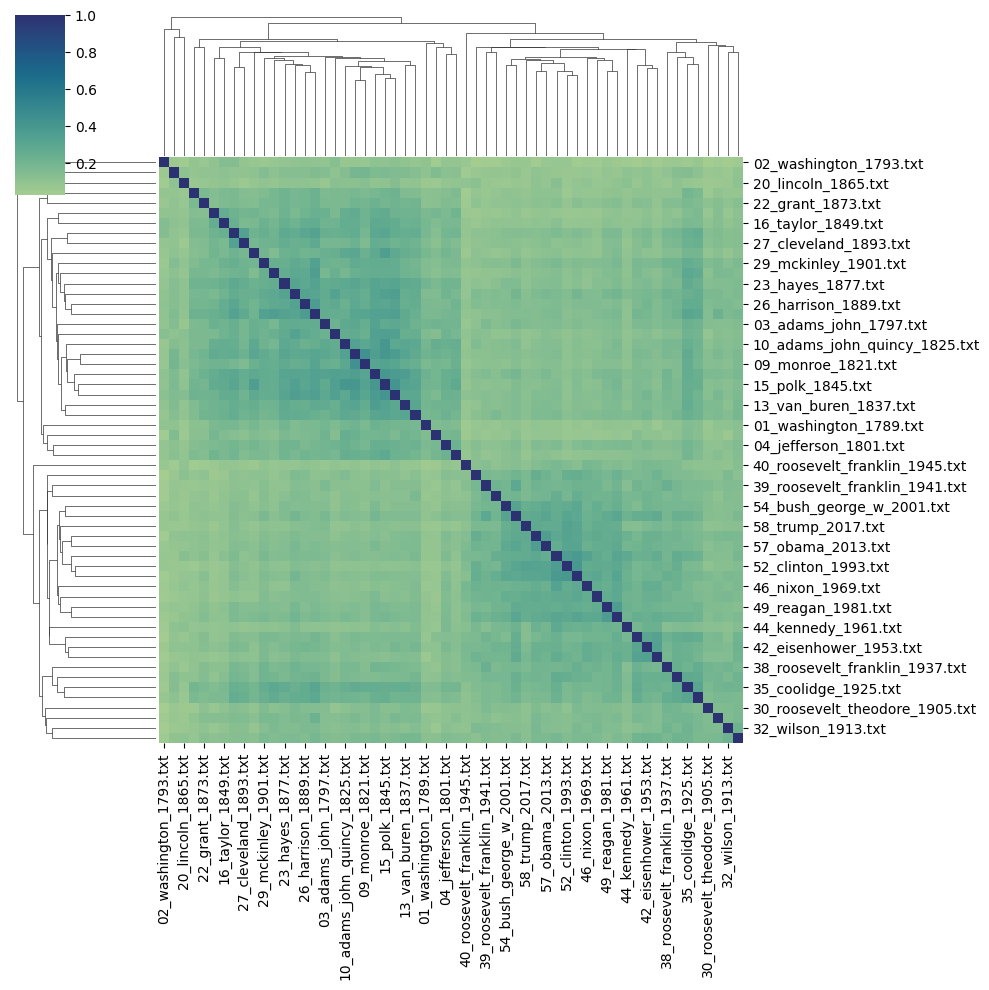

In [98]:
sns.clustermap(cosine_sim_df, annot= False, cmap = "crest")

Select speechs from 10 last presidents

In [110]:
seen  = set()
selected = 0
pattern = r"_(.*?)_"

for i in range(len(data['path'])-1, 0, -1):
    if len(seen) < 10 :
        seen.add(re.findall(pattern, data['path'][i])[0])
        selected += 1        

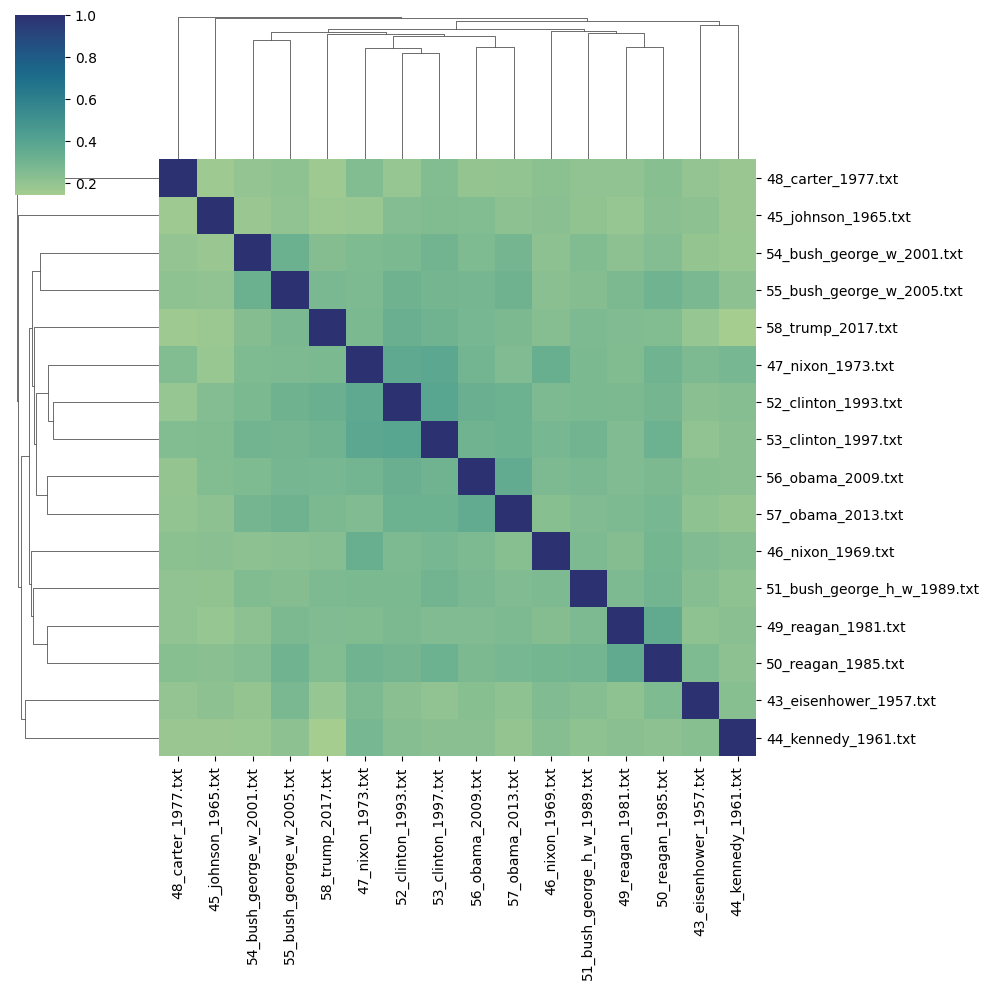

In [111]:
sns.clustermap(cosine_sim_df.iloc[-selected:, -selected:], annot = False, cmap = "crest")